# 6 Fine-tuning for classification

## 6.2 Preparing the dataset

In [1]:
import urllib.request
import zipfile
import os
from pathlib import Path
import torch

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Downloading the file
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

try:
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
except (urllib.error.HTTPError, urllib.error.URLError, TimeoutError) as e:
    print(f"Primary URL failed: {e}. Trying backup URL...")
    url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path) 

sms_spam_collection\SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [2]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Labels", "Text"])
df

,Labels,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [3]:
print(df["Labels"].value_counts())

Labels
ham     4825
spam     747
Name: count, dtype: int64


In [4]:
def create_balanced_dataset(df):
    num_spam = df[df["Labels"] == "spam"].shape[0]
    ham_subset = df[df["Labels"] == "ham"].sample(num_spam, random_state=123)

    balanced_df = pd.concat([ham_subset, df[df["Labels"] == "spam"]])
    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Labels"].value_counts())


Labels
ham     747
spam    747
Name: count, dtype: int64


In [5]:
balanced_df["Labels"] = balanced_df["Labels"].map({"spam": 1, "ham": 0})
balanced_df["Labels"].value_counts()

Labels
0    747
1    747
Name: count, dtype: int64

In [6]:
def random_split(df, train_frac, validation_frac):
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)
    train_end = int(len(df) * train_frac)
    validation_end= train_end + int(len(df) * validation_frac)

    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

## 6.3 Creating data loaders

In [7]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [8]:
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        super().__init__()
        self.data = pd.read_csv(csv_file)

        self.encoded_text = [tokenizer.encode(text) for text in self.data["Text"]]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            self.encoded_text = [encoded_text[:self.max_length] for encoded_text in self.encoded_text]

        self.encoded_text = [encoded_text + [pad_token_id] * (self.max_length - len(encoded_text)) for encoded_text in self.encoded_text]

    def __getitem__(self, index):
        encoded = self.encoded_text[index]
        label = self.data.iloc[index]["Labels"]
        return (torch.tensor(encoded, dtype=torch.long), torch.tensor(label, dtype=torch.long))
    
    def __len__(self):
        return len(self.data)
    
    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_text:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length


In [9]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

120


In [10]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [11]:
# model_maxlength = model.pos_emb.weight.shape[0]

In [12]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)


In [13]:
for input_batch, target_batch in train_loader:
    pass
print("Input batch dimension:", input_batch.shape)
print("Label batch dimension:", target_batch.shape)

for input_batch, target_batch in val_loader:
    pass
print("Input batch dimension:", input_batch.shape)
print("Label batch dimension:", target_batch.shape)

for input_batch, target_batch in test_loader:
    pass
print("Input batch dimension:", input_batch.shape)
print("Label batch dimension:", target_batch.shape)

Input batch dimension: torch.Size([8, 120])
Label batch dimension: torch.Size([8])
Input batch dimension: torch.Size([5, 120])
Label batch dimension: torch.Size([5])
Input batch dimension: torch.Size([4, 120])
Label batch dimension: torch.Size([4])


In [14]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


## 6.4 Initializing a model with pretrained weights

In [15]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True,
}
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [16]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe


In [17]:
from previous_chapters import (
    generate_text_simple,
    text_to_token_ids,
    token_ids_to_text
)

text_1 = "Every effort moves you"
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [18]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


Based on the output, it’s apparent that the model is struggling to follow instructions.
This result is expected, as it has only undergone pretraining and lacks instruction
fine-tuning. So, let’s prepare the model for classification fine-tuning.

## 6.5 Adding a classification head

!["6.9"](img/6.9.png)

In [19]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

In [20]:
# Freeze the model
for param in model.parameters():
    param.requires_grad = False

In [21]:
torch.manual_seed(123)
num_classes = 2

model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

In [22]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True
for param in model.final_norm.parameters():
    param.requires_grad = True

In [23]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [24]:
with torch.no_grad():
    outputs = model(inputs)
print(outputs.shape)

torch.Size([1, 4, 2])


In [25]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


## 6.6 Calculating the classification loss and accuracy

In [26]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())
print(probas.shape, label.shape)

Class label: 1
torch.Size([1, 2]) torch.Size([])


In [27]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]
            
            predicted_labels = torch.argmax(logits, dim=-1)
            num_examples += predicted_labels.shape[0]
            correct_predictions += ((predicted_labels == target_batch).sum().item())
        else:
            break

    return correct_predictions / num_examples

In [28]:
device = "xpu" if torch.xpu.is_available() else "cpu"
model.to(device)

torch.manual_seed(123)

train_acc = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_acc = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_acc = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_acc*100:.2f}%")
print(f"Val accuracy: {val_acc*100:.2f}%")
print(f"Test accuracy: {test_acc*100:.2f}%")

Training accuracy: 46.25%
Val accuracy: 45.00%
Test accuracy: 48.75%


In [29]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)

    logits = model(input_batch)[:, -1, :]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [30]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    model.eval()
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss
        else:
            break
    
    return total_loss / num_batches

In [31]:
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Val loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.453
Val loss: 2.583
Test loss: 2.322


## 6.7 Fine-tuning the model on supervised data

In [32]:
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            examples_seen += input_batch.shape[0]
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss.cpu())
                val_losses.append(val_loss.cpu())
                print(f"Ep {epoch+1} (Step {global_step:06d}) : "
                      f"Train loss {train_loss:.3f}, " 
                      f"Eval Loss: {val_loss:.3f}"
                      )
                
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)

        print(f"Train accuracy: {train_accuracy*100:.2f} % | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f} %")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
    
    return train_losses, val_losses, train_accs, val_accs, examples_seen

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    
    model.train()
    return train_loss, val_loss

In [33]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5

train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq=50, eval_iter=5)

end_time = time.time()
execution_time = (end_time - start_time) / 60
print(f"Training completed in {execution_time:.2f} minutes.")

Ep 1 (Step 000000) : Train loss 2.153, Eval Loss: 2.392
Ep 1 (Step 000050) : Train loss 0.617, Eval Loss: 0.637
Ep 1 (Step 000100) : Train loss 0.523, Eval Loss: 0.557
Train accuracy: 70.00 % | Validation accuracy: 72.50 %
Ep 2 (Step 000150) : Train loss 0.561, Eval Loss: 0.489
Ep 2 (Step 000200) : Train loss 0.419, Eval Loss: 0.397
Ep 2 (Step 000250) : Train loss 0.409, Eval Loss: 0.353
Train accuracy: 82.50 % | Validation accuracy: 85.00 %
Ep 3 (Step 000300) : Train loss 0.333, Eval Loss: 0.320
Ep 3 (Step 000350) : Train loss 0.340, Eval Loss: 0.306
Train accuracy: 90.00 % | Validation accuracy: 90.00 %
Ep 4 (Step 000400) : Train loss 0.136, Eval Loss: 0.200
Ep 4 (Step 000450) : Train loss 0.153, Eval Loss: 0.132
Ep 4 (Step 000500) : Train loss 0.222, Eval Loss: 0.137
Train accuracy: 100.00 % | Validation accuracy: 97.50 %
Ep 5 (Step 000550) : Train loss 0.207, Eval Loss: 0.143
Ep 5 (Step 000600) : Train loss 0.083, Eval Loss: 0.074
Train accuracy: 100.00 % | Validation accuracy: 97.

In [34]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

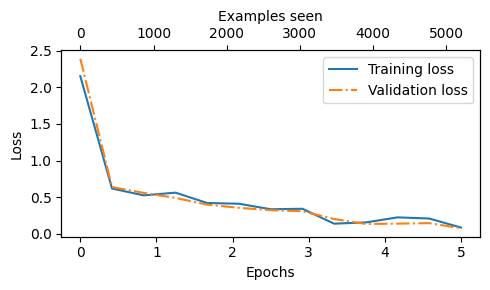

In [35]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

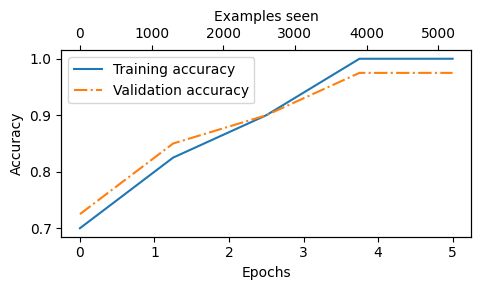

In [36]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [37]:
train_acc = calc_accuracy_loader(train_loader, model, device)
val_acc = calc_accuracy_loader(val_loader, model, device)
test_acc = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_acc*100:.2f}%")
print(f"Val accuracy: {val_acc*100:.2f}%")
print(f"Test accuracy: {test_acc*100:.2f}%")

Training accuracy: 97.21%
Val accuracy: 97.32%
Test accuracy: 95.67%


## 6.8 Using the LLM as a spam classifier

In [38]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[1]

    input_ids = input_ids[:min(max_length, supported_context_length)]

    input_ids += [pad_token_id] * (max_length - len(input_ids))

    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)

    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]
    
    predicted_labels = torch.argmax(logits, dim=-1).item()
    return "spam" if predicted_labels == 1 else "not spam"



In [39]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [40]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [41]:
torch.save(model.state_dict(), "review_classifier.pth")

In [42]:
model_state_dict = torch.load("review_classifier.pth", map_location=device, weights_only=True)
model.load_state_dict(model_state_dict)

<All keys matched successfully>